In [1]:
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("SingleR")
    library("scRNAseq")
    library("scater")
    library("pheatmap")
})

In [2]:
load("./PP1_data/FLaLP_PP1.rda")

In [4]:
tic()
ref       <- ImmGenData()
mat       <- GetAssayData(seu, slot="data")
pred.immgen.fine <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
pred.immgen.main <- SingleR(test = mat, ref = ref, labels = ref$label.main)

seu[["pred.immgen.fine"]]      <-pred.immgen.fine$labels
seu[["pred.immgen.finepruned"]]<-pred.immgen.fine$pruned.labels

seu[["pred.immgen.main"]]      <-pred.immgen.main$labels
seu[["pred.immgen.mainpruned"]]<-pred.immgen.main$pruned.labels
toc()

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

snapshotDate(): 2019-10-22

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

downloading 1 resources

retrieving 1 resource

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

loading from cache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

see ?SingleR and browseVignettes('SingleR') for documentation

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

downloading 1 resources

retrieving 1 resource

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

loading from cache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache /tmp/RtmppZYq0K/BiocFileCache

Using temporary cache

1539.202 sec elapsed


Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


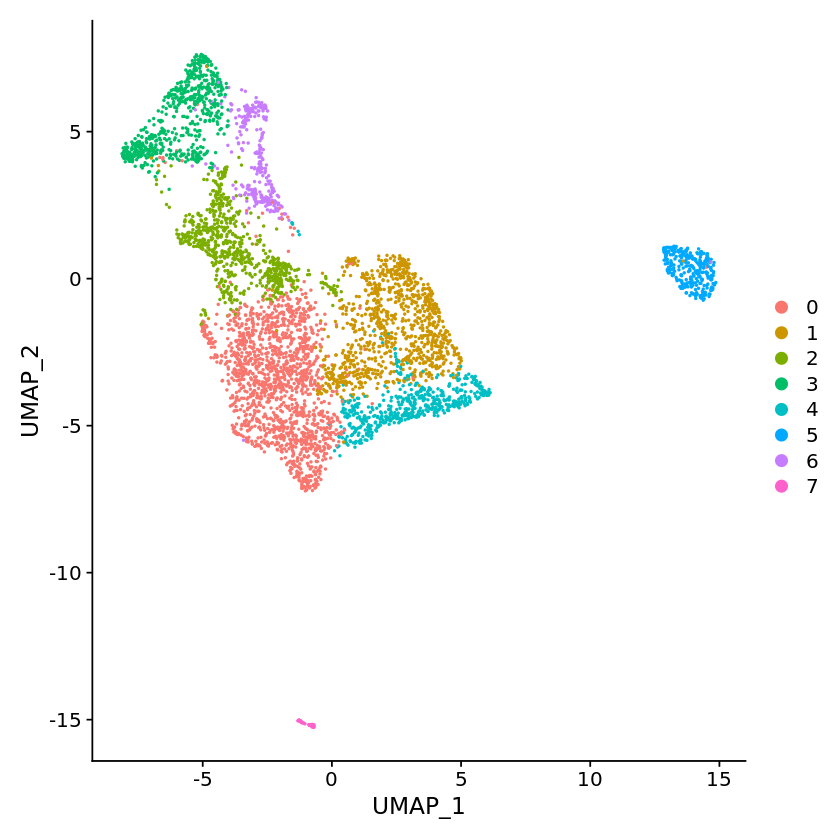

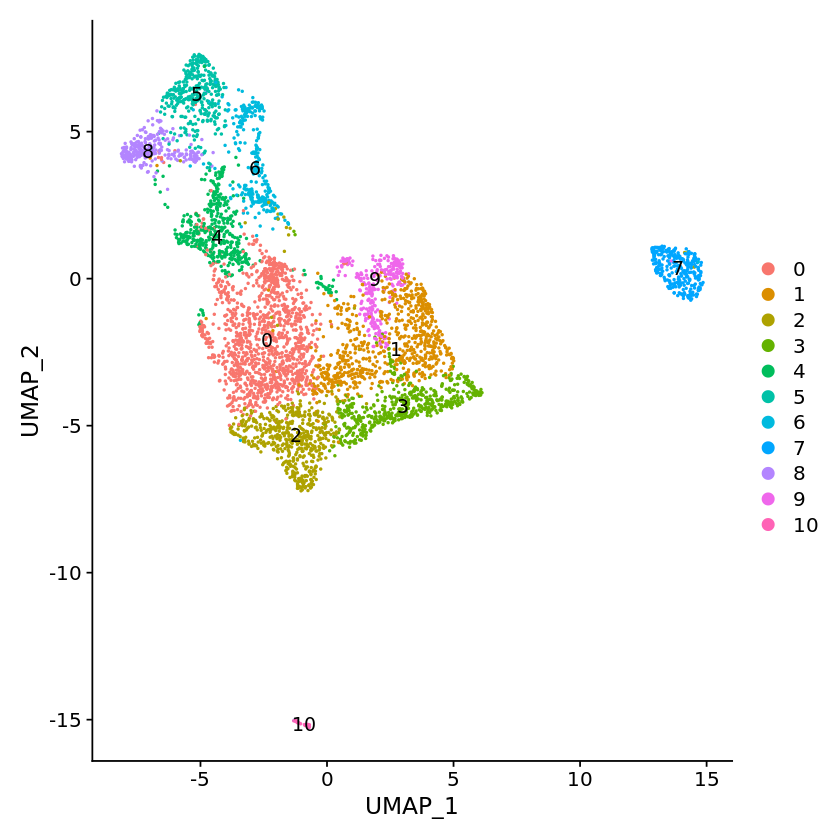

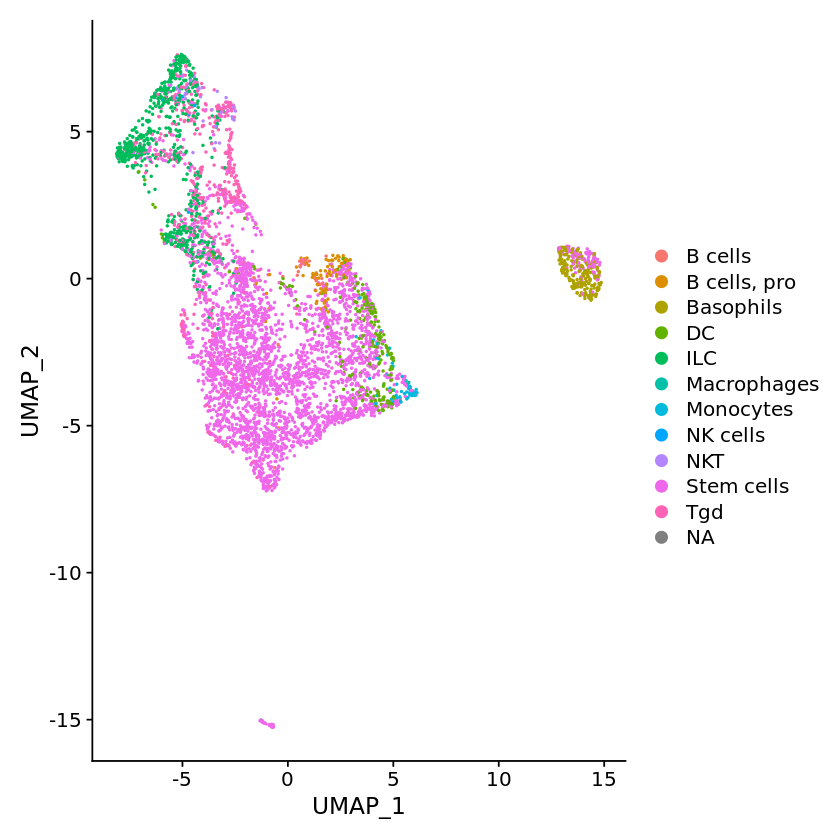

In [7]:
options(repr.plot.width=7, repr.plot.height=7)
DimPlot(seu, group.by="RNA_snn_res.0.3")
DimPlot(seu, group.by="RNA_snn_res.0.5", label=T)
DimPlot(seu, group.by="pred.immgen.mainpruned")

In [6]:
seu->seu.all

In [8]:
Idents(seu)<-"RNA_snn_res.0.5"
tic("DE")
markers <- FindAllMarkers(seu, only.pos = FALSE, min.pct = 0.25, 
                          logfc.threshold = 0.25, return.thresh = 0.01)
# Filter
markers <- markers[ markers$p_val_adj<0.01, ]
# Sort
markers <- markers[ order(markers$cluster, -markers$avg_logFC), ]
toc()


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10



DE: 255.446 sec elapsed


In [9]:
cluster_names <- unique(sort(seu@meta.data$"RNA_snn_res.0.5"))
seu_subsets <-list()
for (cluster in cluster_names){
    cluster<-as.character(cluster)
    seu_subsets[[cluster]]<-subset(seu, RNA_snn_res.0.5==cluster)
}

In [14]:
putative_doublets<-c()

# C0

In [11]:
seu <- seu_subsets[["0"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["0"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 17.671 sec elapsed


Computing nearest neighbor graph

Computing SNN



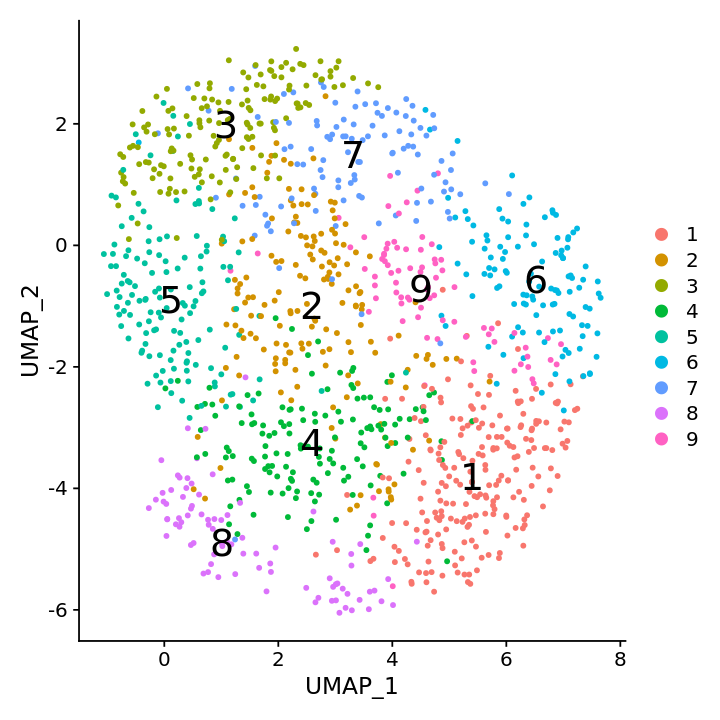

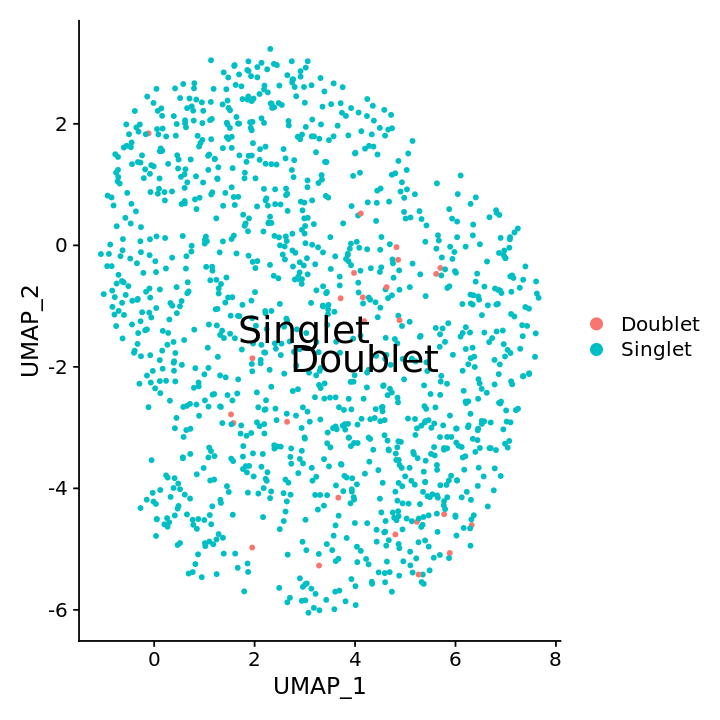

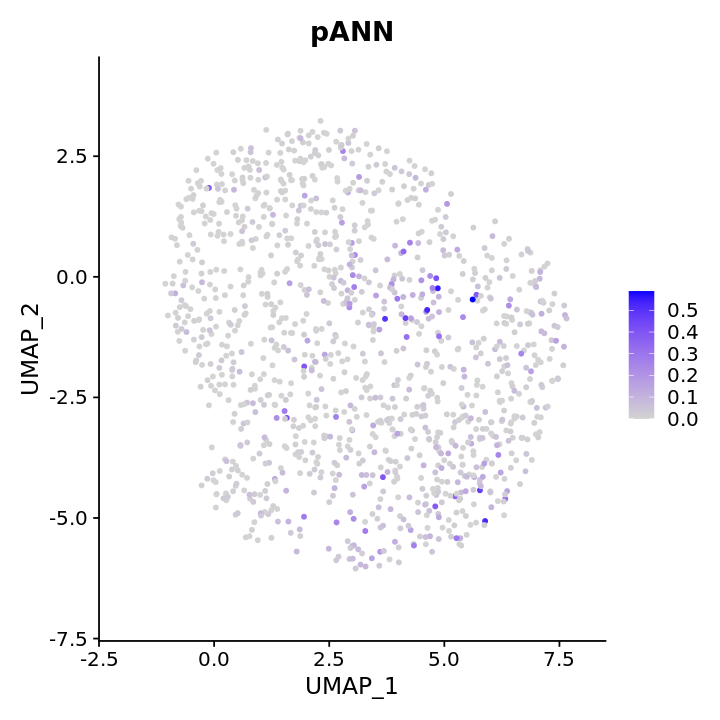

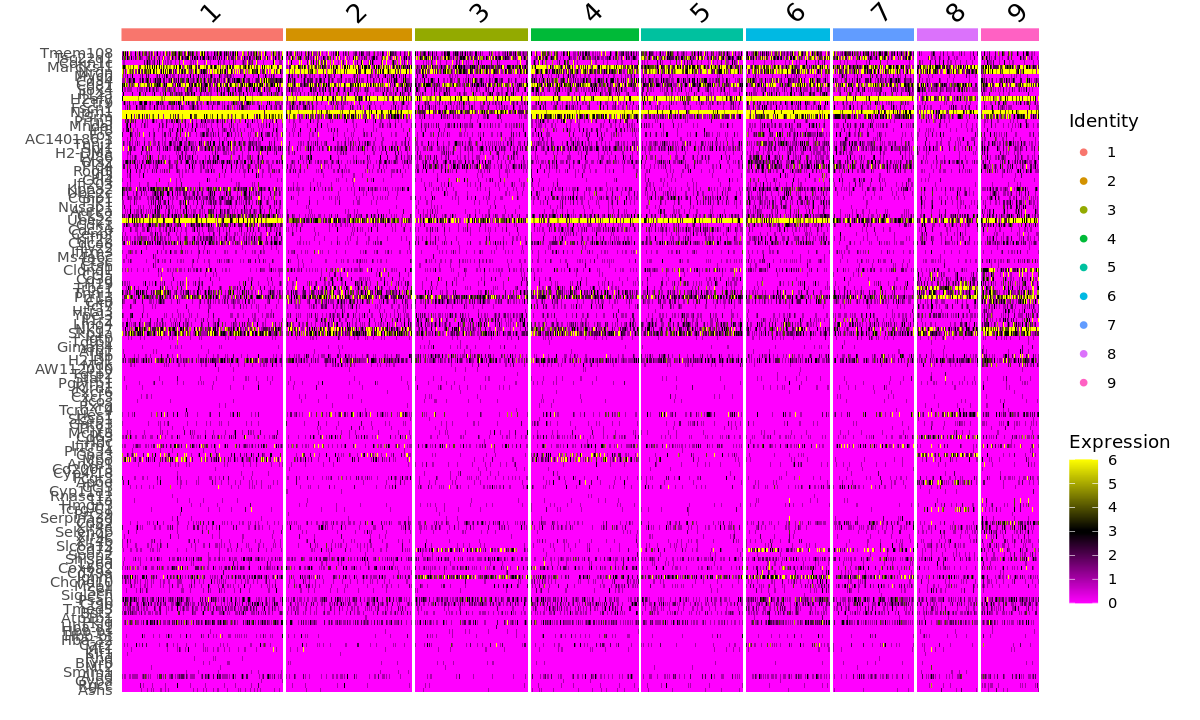

In [13]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [15]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C1

In [17]:
seu <- seu_subsets[["1"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["1"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 5.458 sec elapsed


Computing nearest neighbor graph

Computing SNN



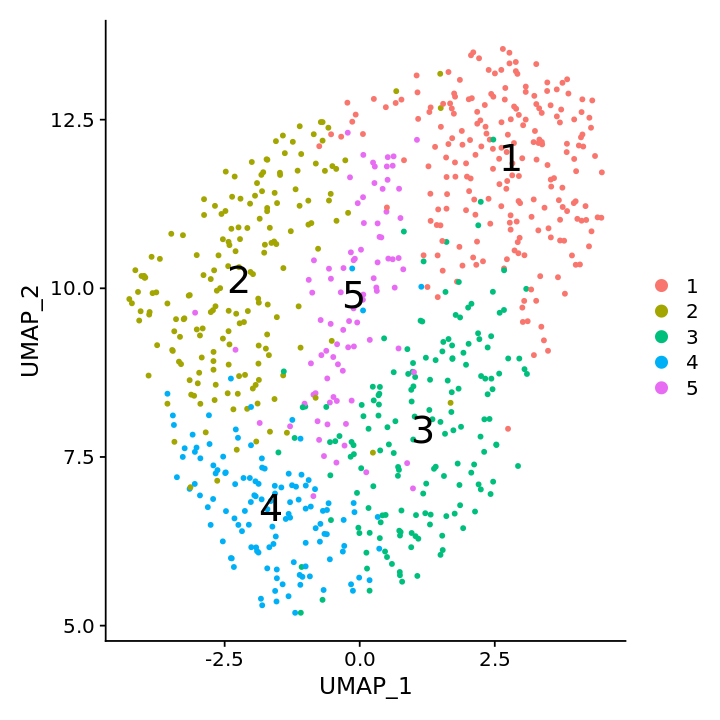

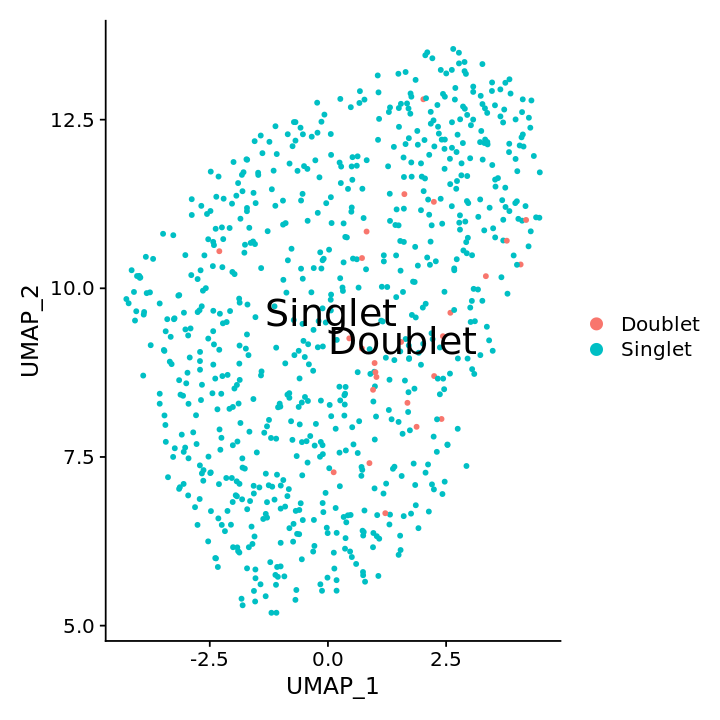

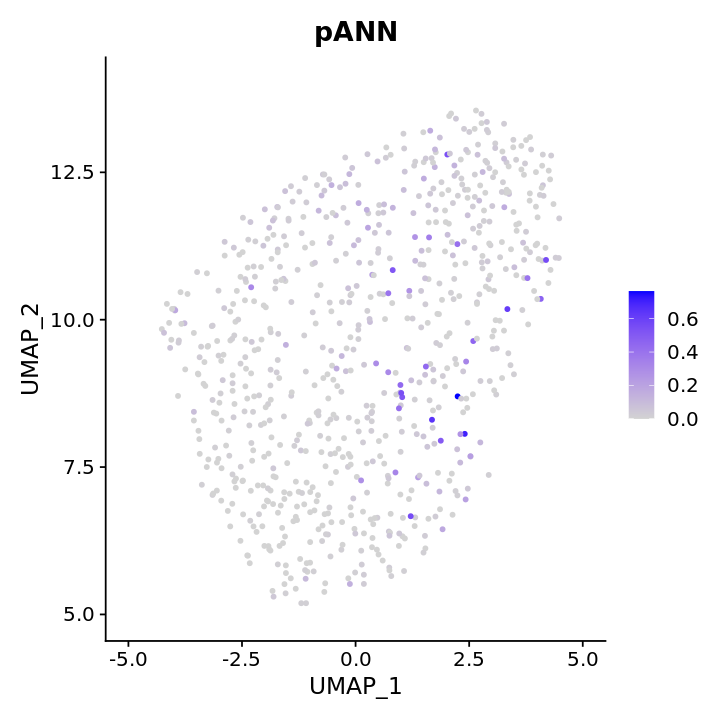

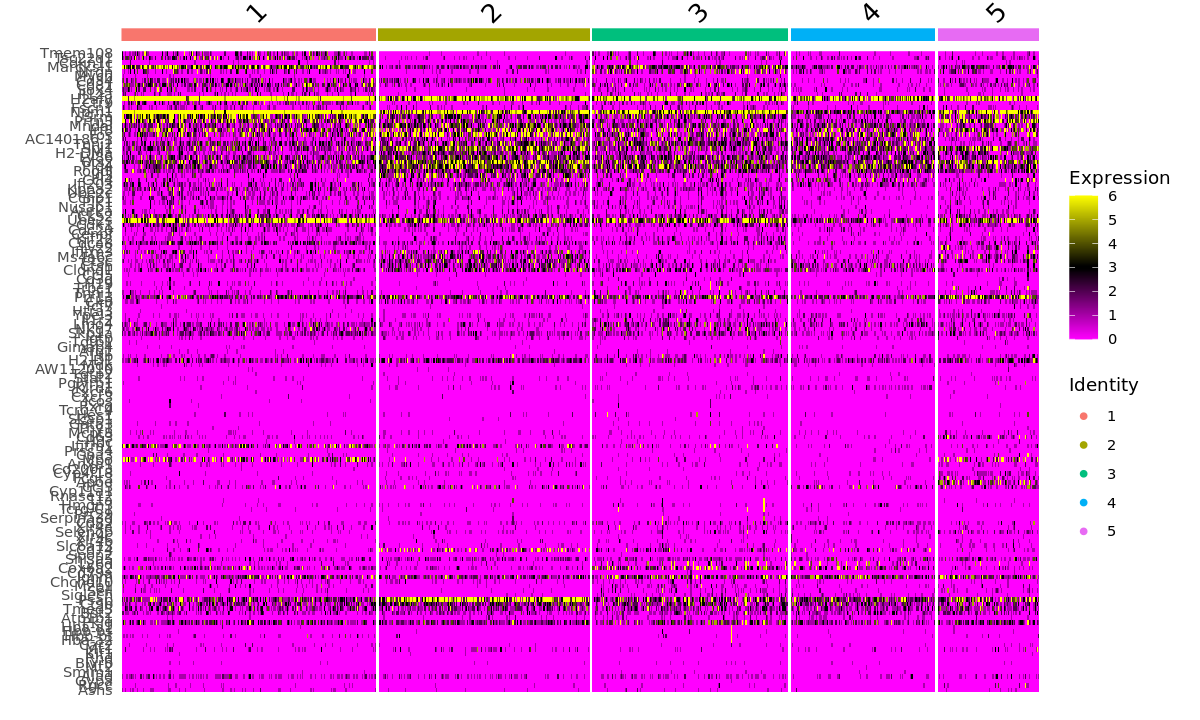

In [18]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [19]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C2

In [20]:
seu <- seu_subsets[["2"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["2"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.301 sec elapsed


Computing nearest neighbor graph

Computing SNN



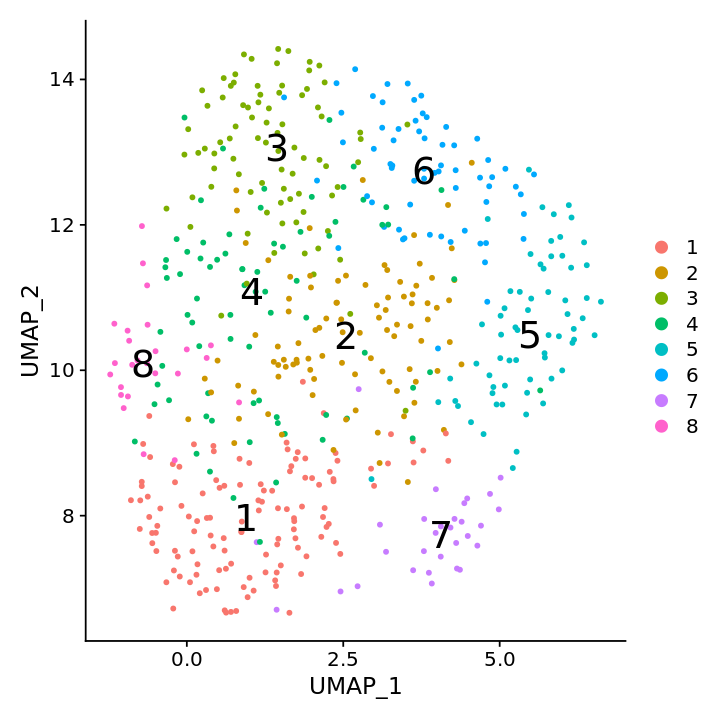

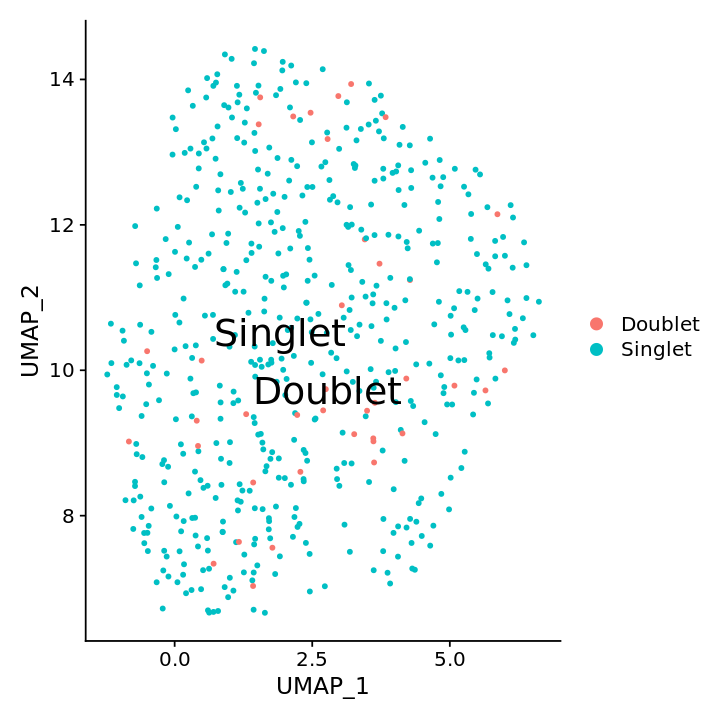

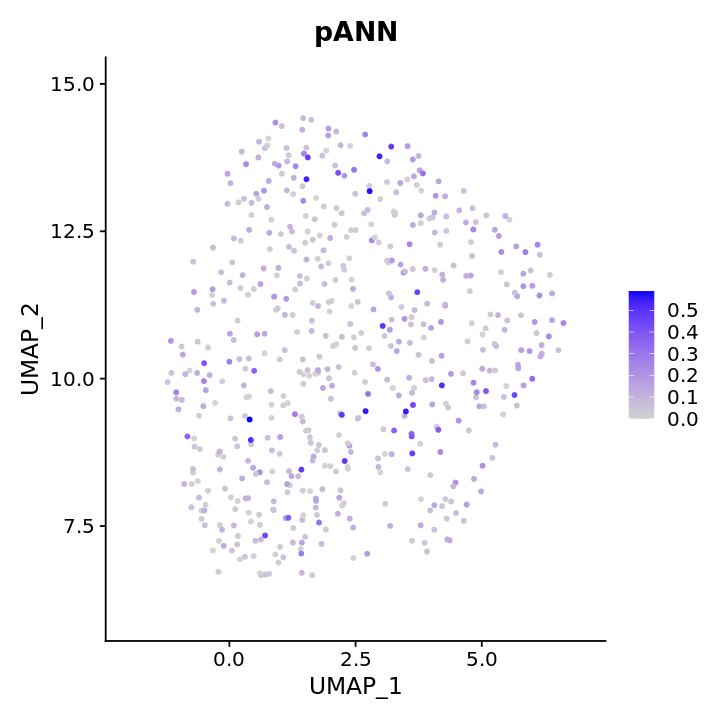

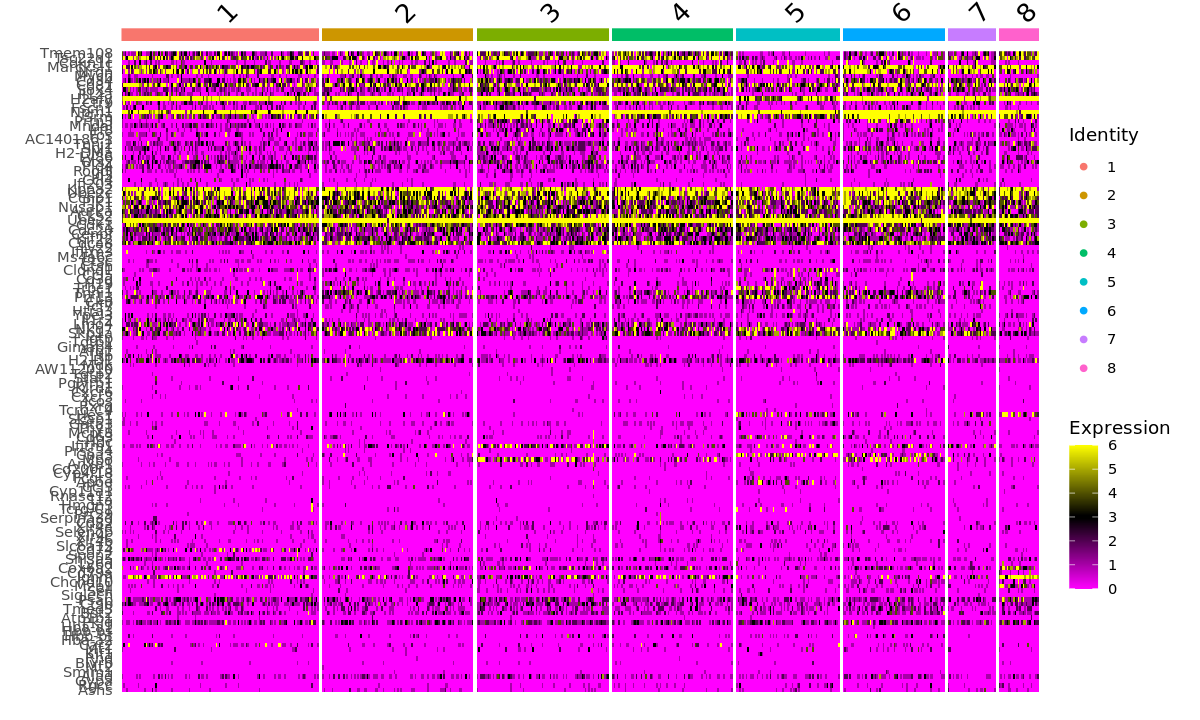

In [22]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [23]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C3

In [25]:
seu <- seu_subsets[["3"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["3"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.53 sec elapsed


Computing nearest neighbor graph

Computing SNN



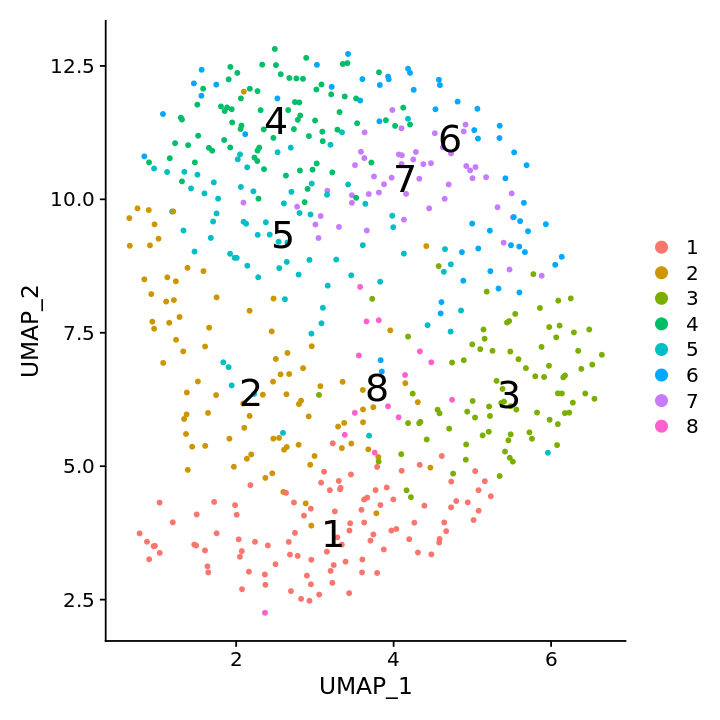

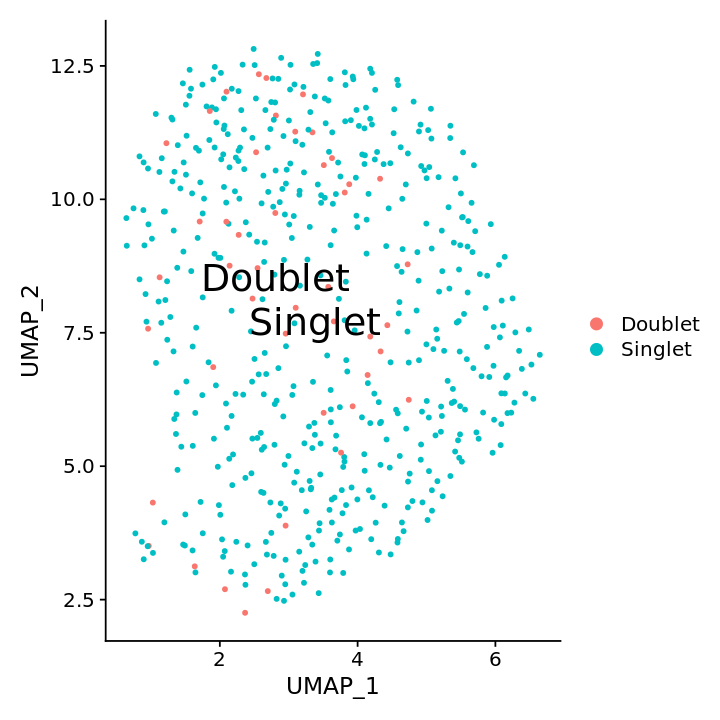

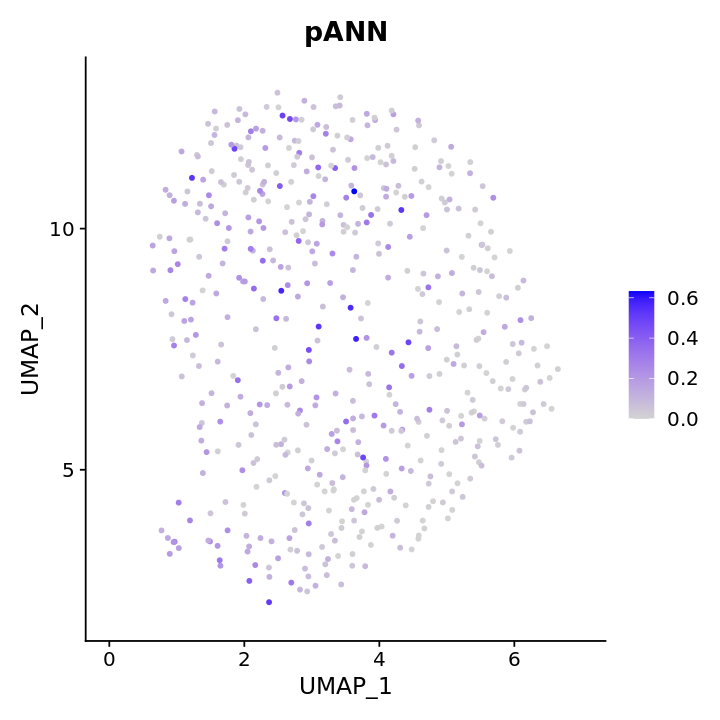

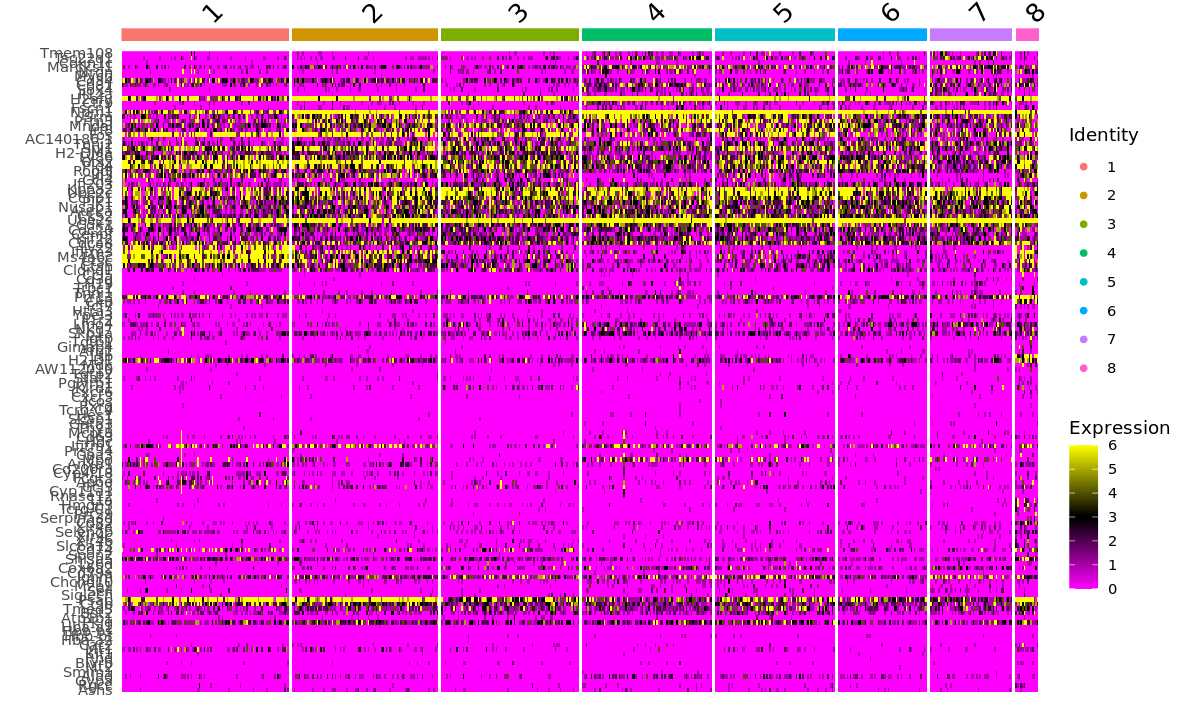

In [26]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [27]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C4

In [28]:
seu <- seu_subsets[["4"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["4"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 4.072 sec elapsed


Computing nearest neighbor graph

Computing SNN



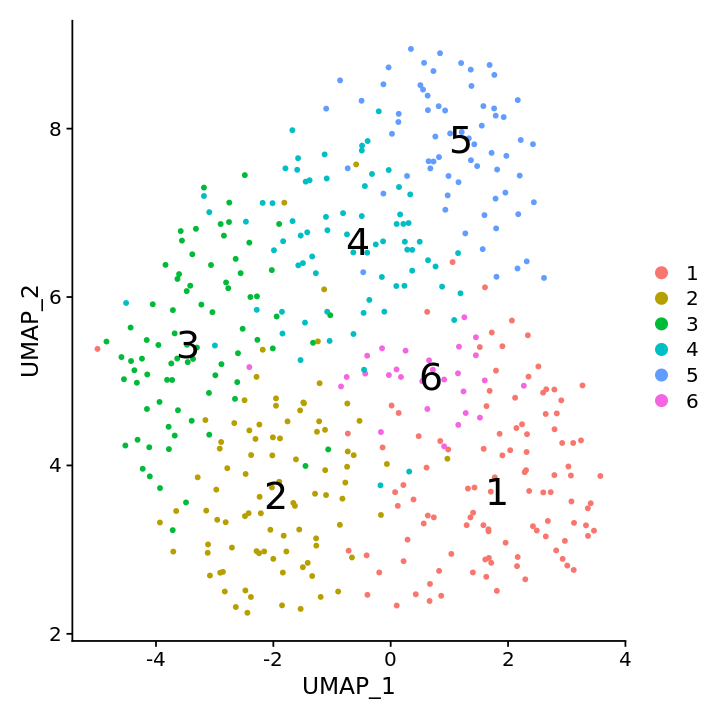

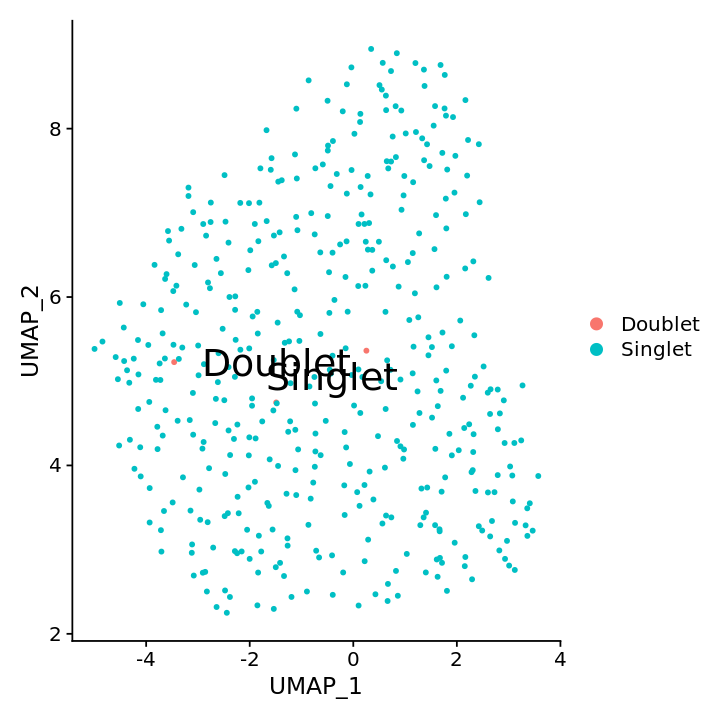

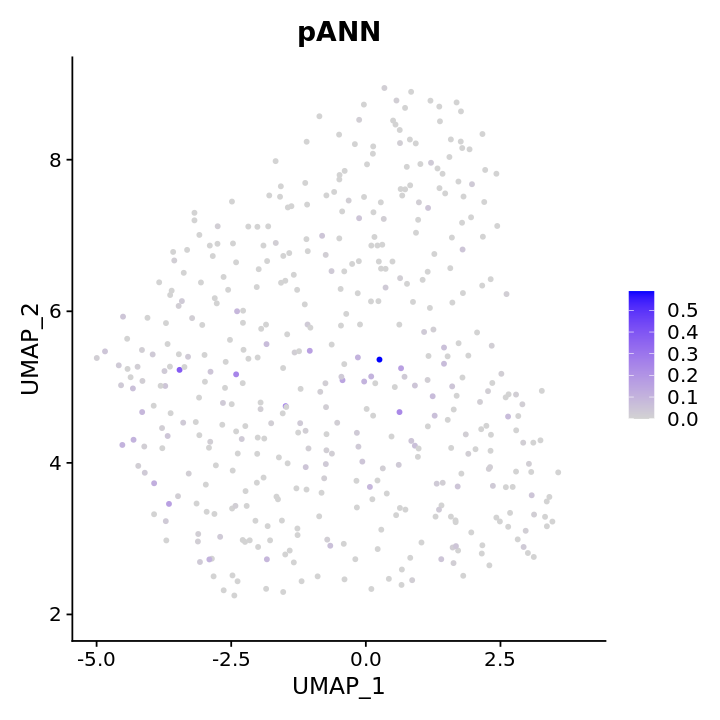

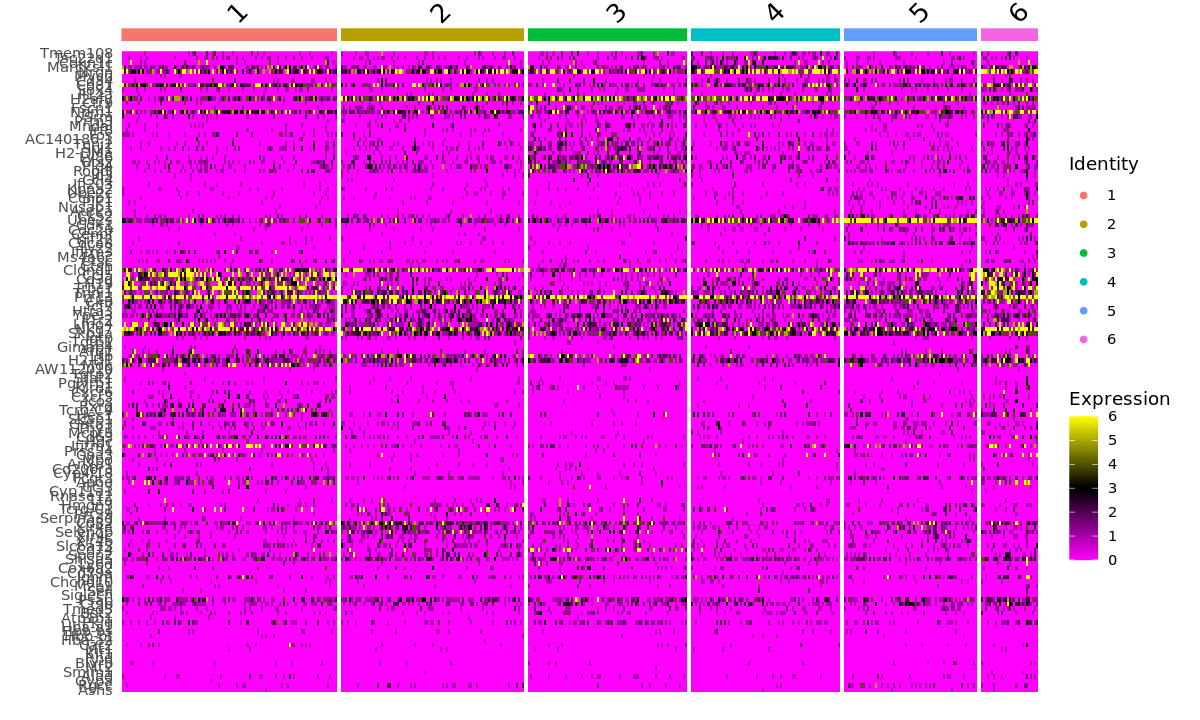

In [29]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [30]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C5

In [31]:
seu <- seu_subsets[["5"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["5"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 3.337 sec elapsed


Computing nearest neighbor graph

Computing SNN



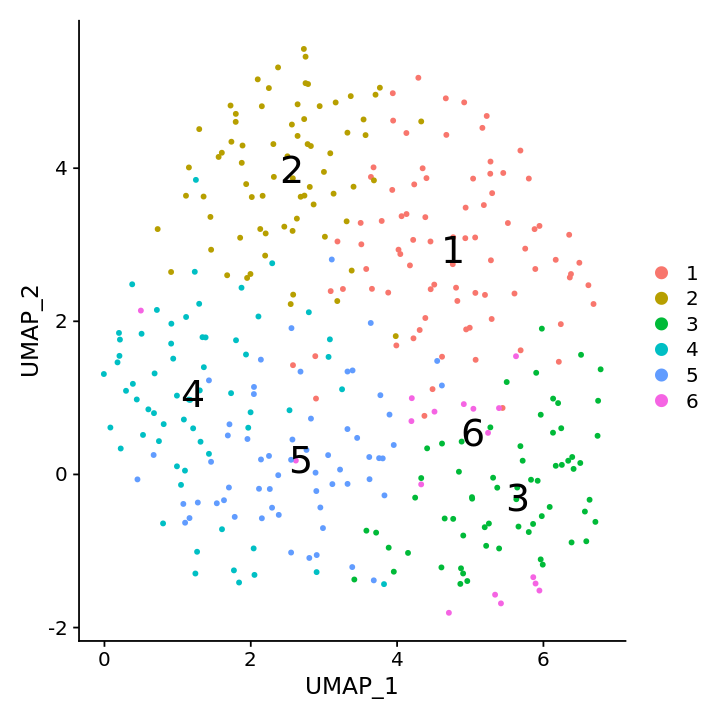

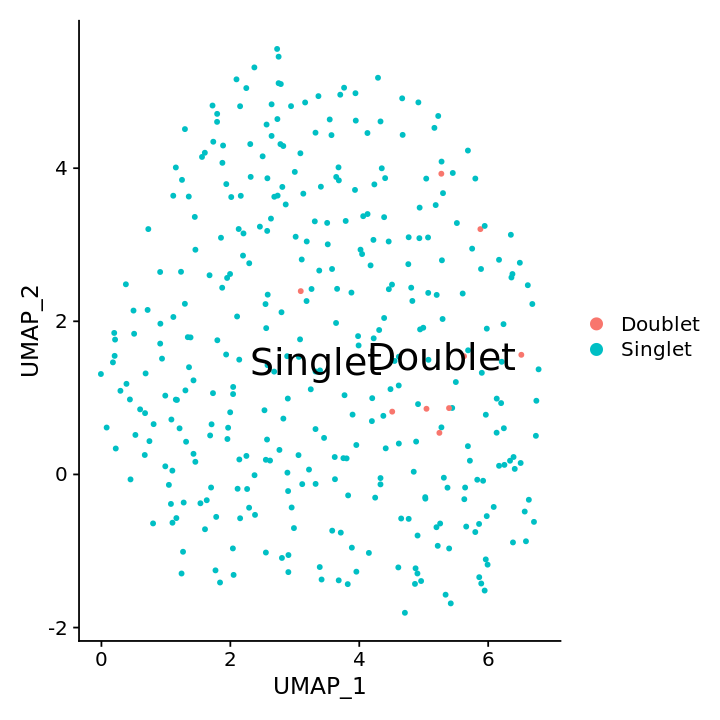

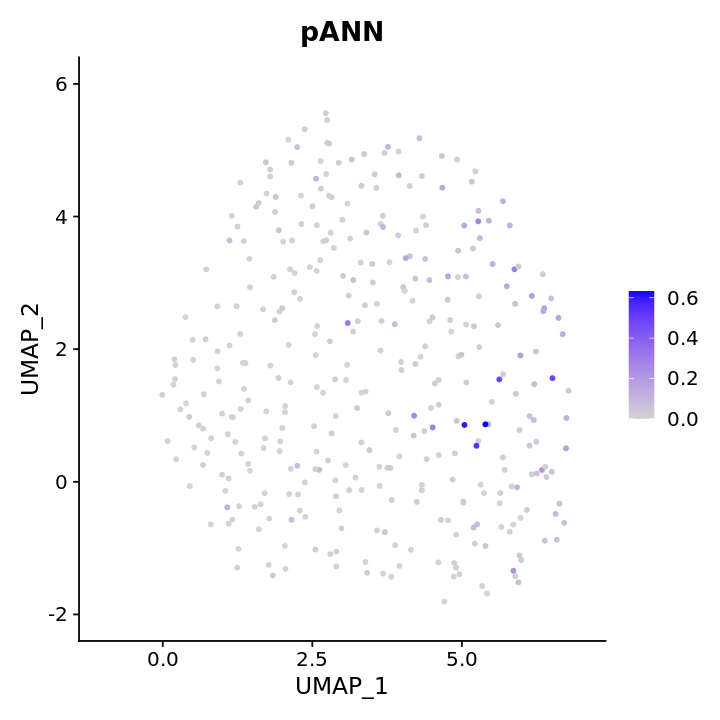

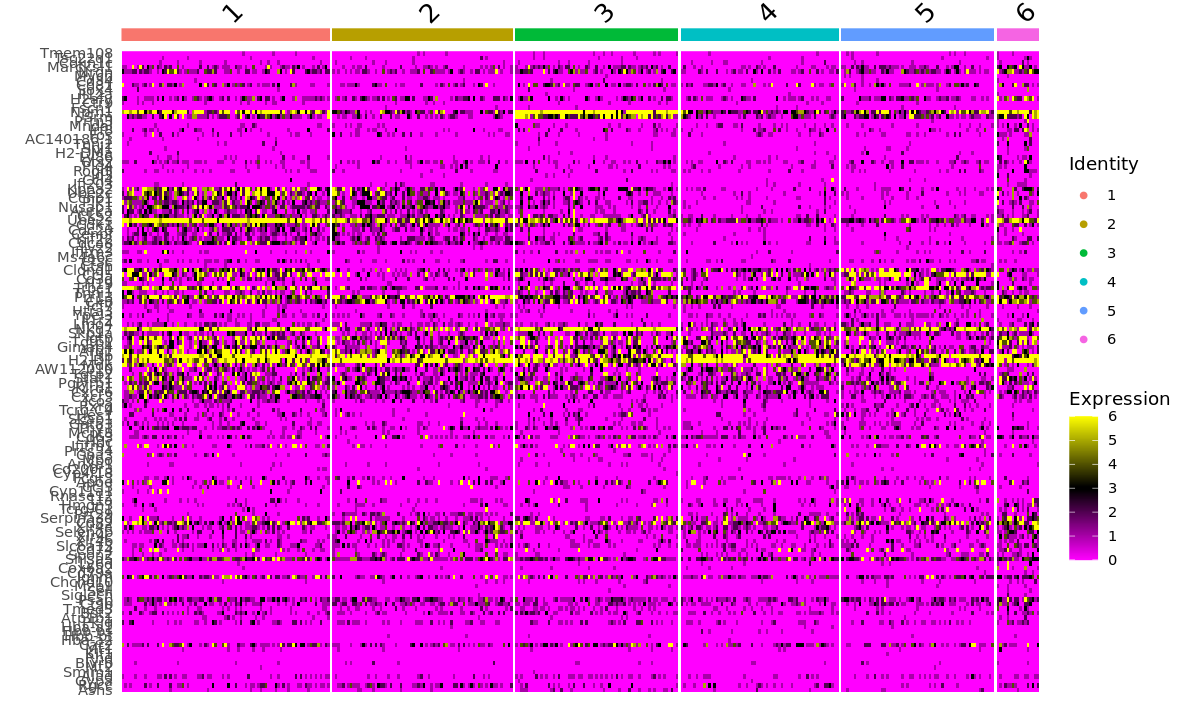

In [33]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [34]:
barcodes<-colnames(subset(seu,leiden_res.1.2=="6"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C6

In [35]:
seu <- seu_subsets[["6"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["6"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 3.354 sec elapsed


Computing nearest neighbor graph

Computing SNN



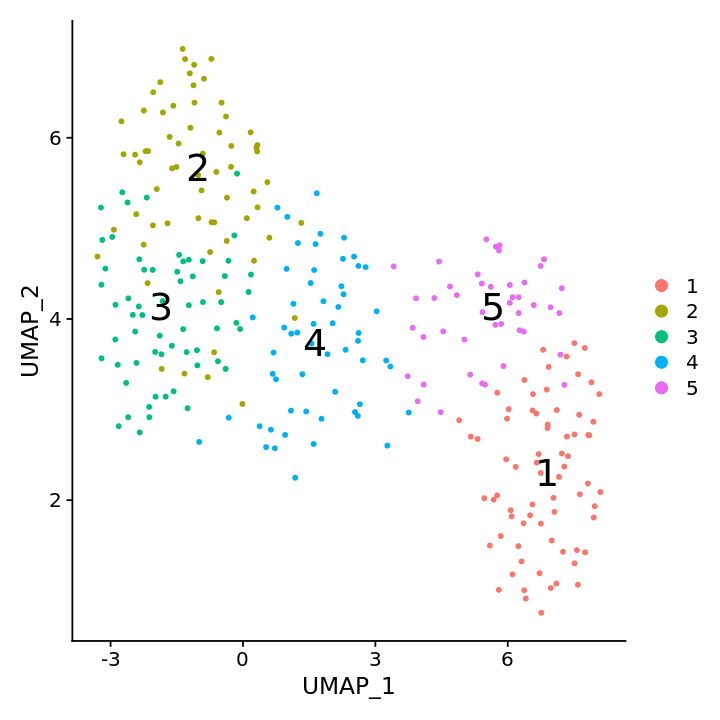

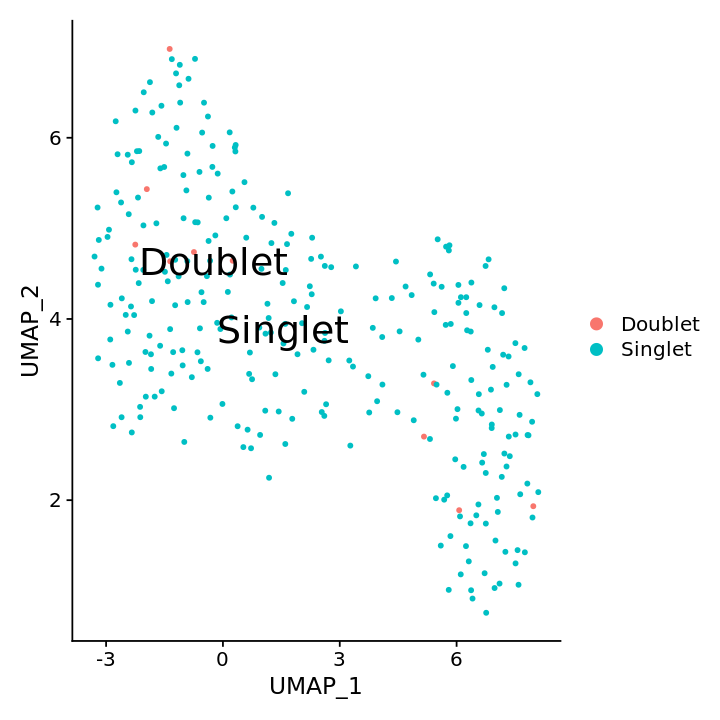

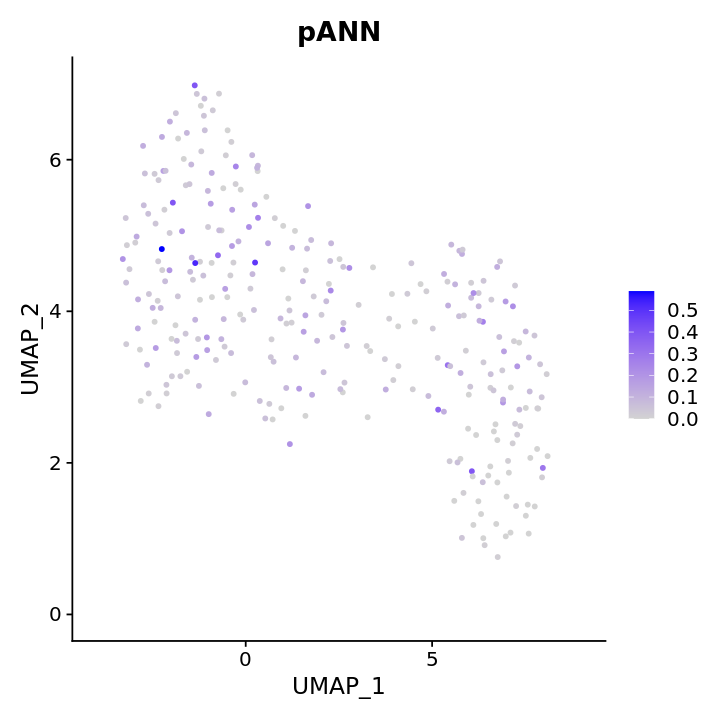

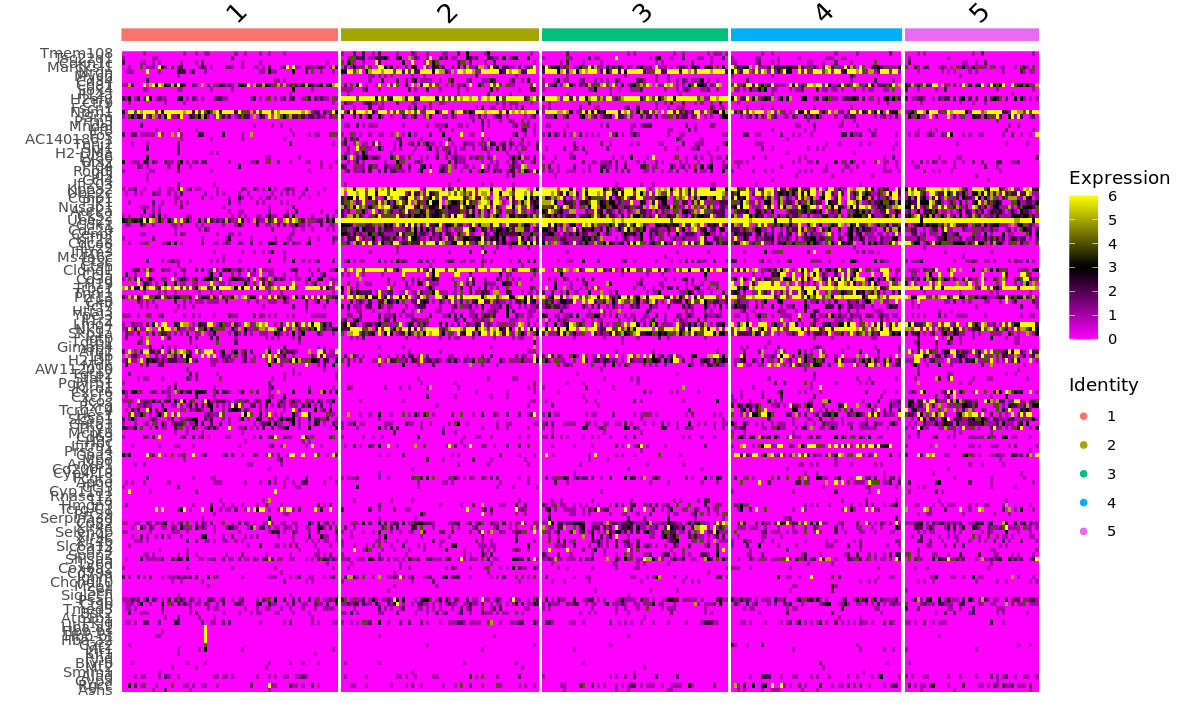

In [36]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [37]:
barcodes<-colnames(subset(seu,doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C8

In [39]:
seu <- seu_subsets[["8"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=20, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:20, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["8"]]

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.1553”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.7684e-16”
Centering and scaling data matrix



Renormalization and Dimensionality reduction: 3.087 sec elapsed


Computing nearest neighbor graph

Computing SNN



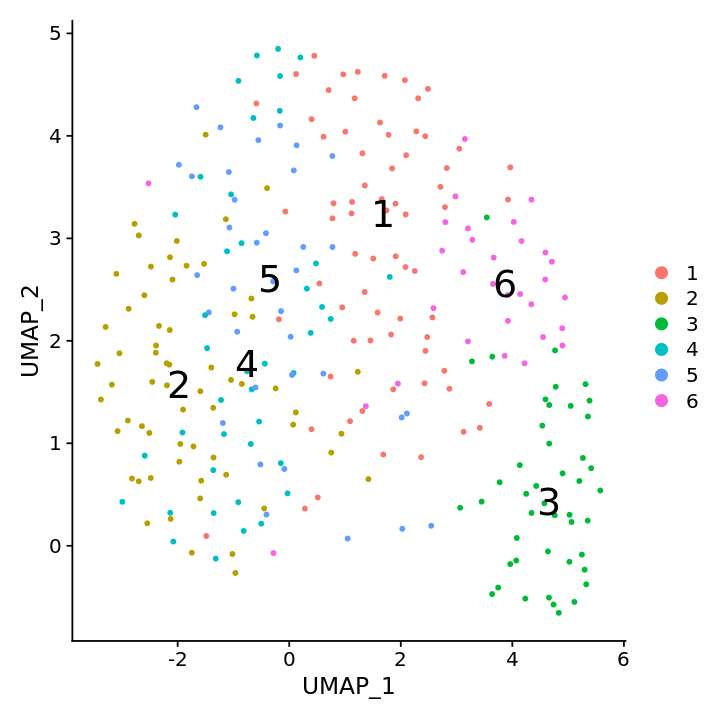

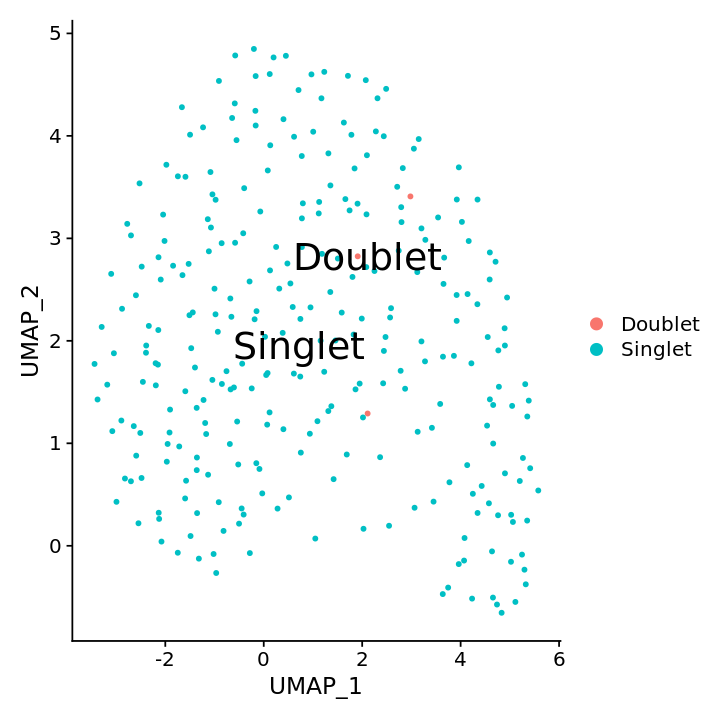

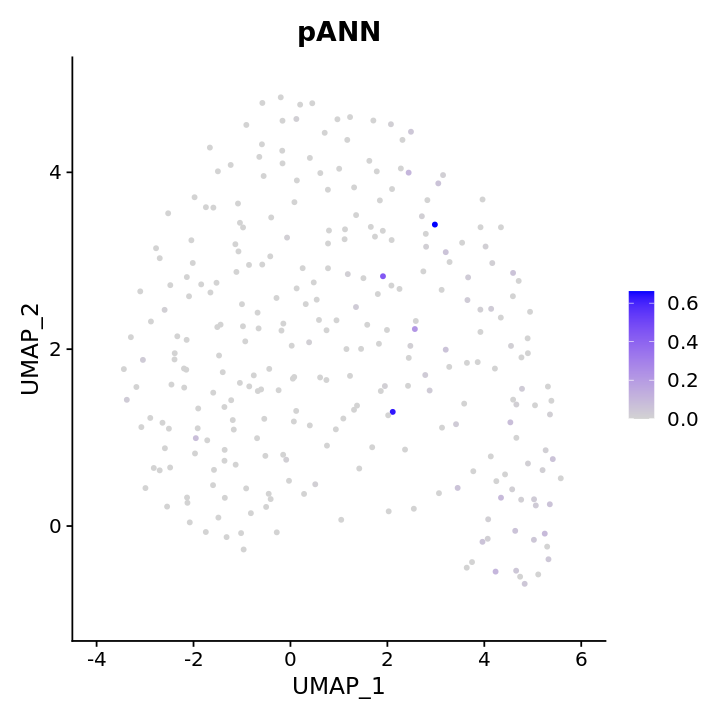

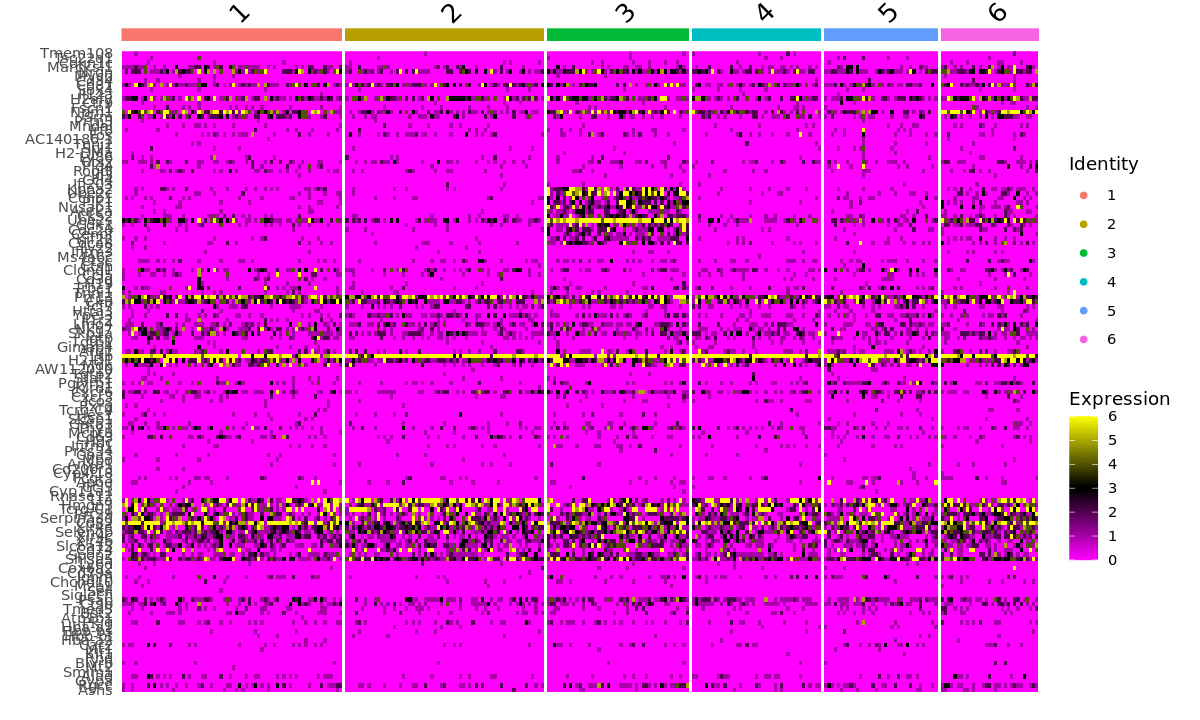

In [41]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [42]:
barcodes<-colnames(subset(seu,leiden_res.1.2=="3"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C9

In [43]:
seu <- seu_subsets[["9"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multiprocess", workers = 8)
options(future.globals.maxSize = 3*1000 * 1024^2)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["9"]]

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 3.217 sec elapsed


Computing nearest neighbor graph

Computing SNN



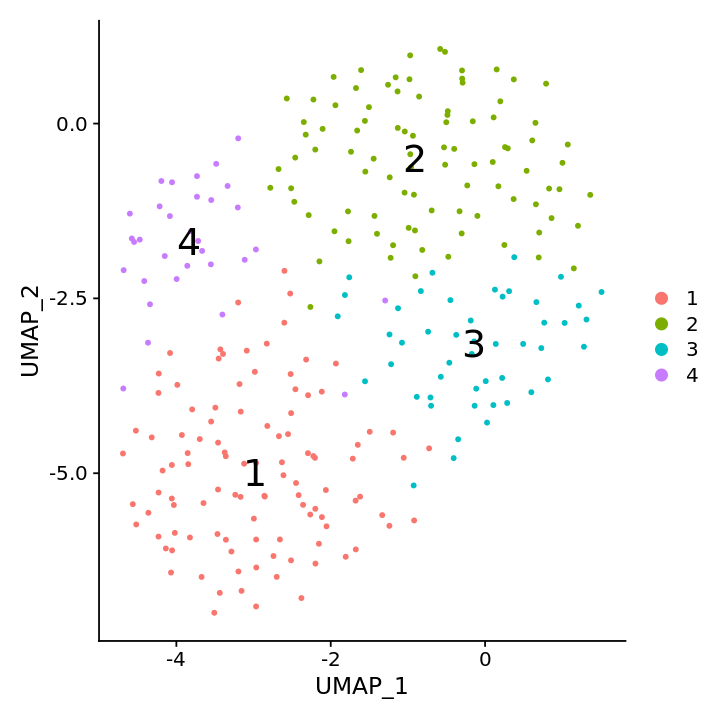

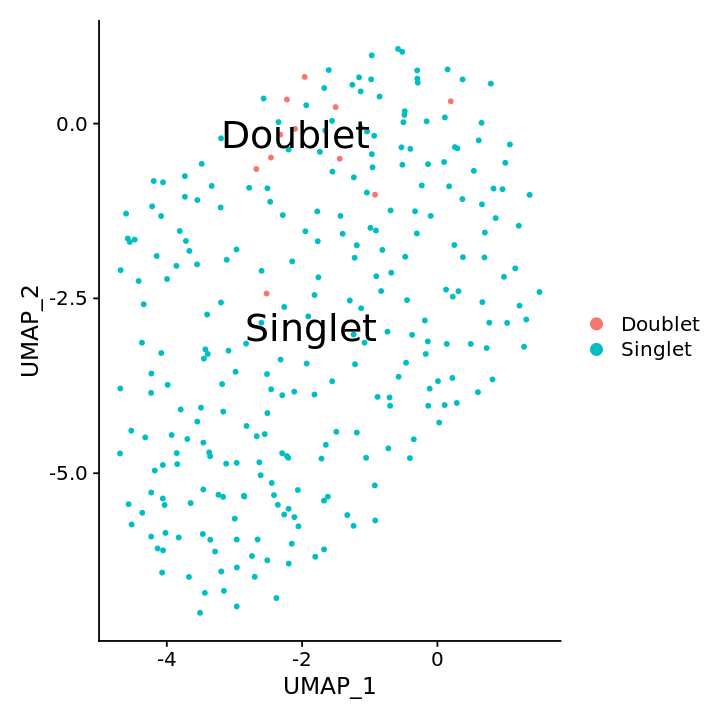

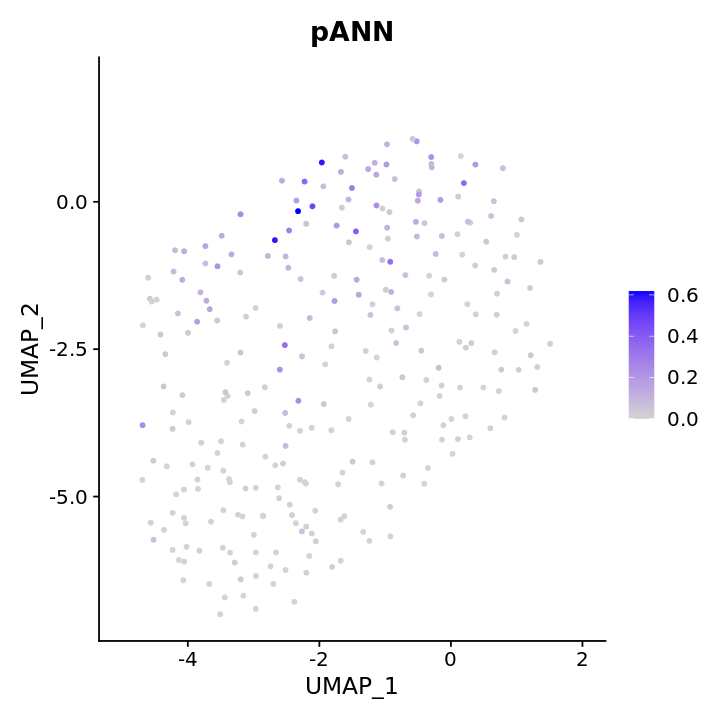

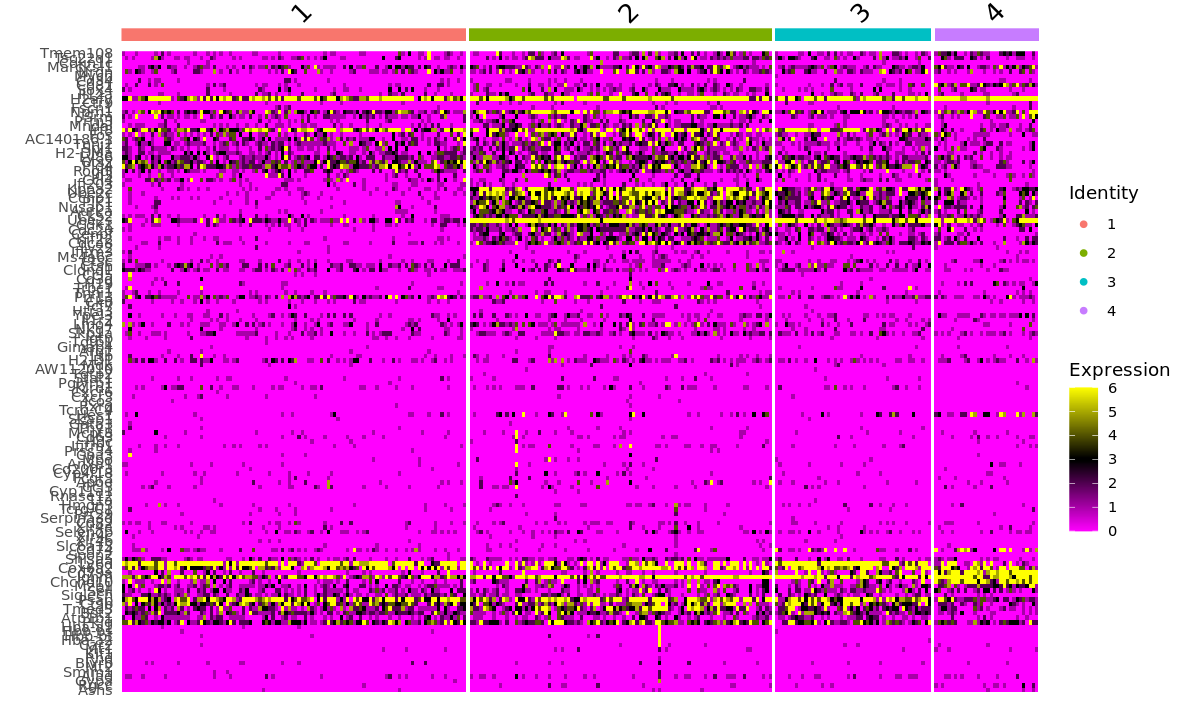

In [46]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_logFC)
options(repr.plot.width=10, repr.plot.height=6)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [47]:
barcodes<-colnames(subset(seu,leiden_res.0.7=="2"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

In [49]:
length(putative_doublets)/ncol(seu.all)

[1] 0.06104024

In [50]:
save(putative_doublets,file = "200220-FLaLP-PP1(multiplets).rda", compress=T)